In [60]:
import pandas as pd
import numpy as np
import seaborn as sns
import scipy.stats as stats
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.formula.api import ols
import matplotlib.pyplot as plt

In [29]:
weights_data = pd.read_excel('../Data/LECO/Soil/LECO processing Akron Soil April 2022 Samples Almost complete.xlsx', sheet_name='Data from LECO and Soi Weights ', engine='openpyxl')
weights_data = weights_data[~weights_data['2021  Treatment'].isna()]
weights_data['2021 Irr Trt'] = weights_data['2021 Irr Trt'].astype(int)
weights_data['2021 N Treatment'] = weights_data['2021 N Treatment'].astype(int)
weights_data['Depth'] = weights_data['Depth'].replace({'30-120 ': '30-120'})
weights_data['Depth (top)'] = [int(x.split('-')[0]) for x in weights_data['Depth']]
print(weights_data.shape)
weights_data.head()

(295, 21)


,Analysis Date,Method,Name,Sample Mass,Mass Cat,Carbon,Nitrogen,Total N ppm,N lbs/acre (Plant available 2% of Total N),TinNumber,...,Plot(Depth(cm)),Depth,Starting Depth,DepthPaste,Exclude,2021 Treatment,2021 Irr Trt,2021 N Treatment,Notes,Depth (top)
0,2022-05-19 16:32:40,SOIL (Mead),906,0.3590,0.35,0.00895,0.000850,850.0,34.00,2001,...,14(0-15),0-15,0.0,14(0-15),No,221.0,2,1,Excluded a few that were replaced,0
1,2022-05-19 16:37:32,SOIL (Mead),906,0.3518,0.35,0.00885,0.000842,842.0,33.68,2001,...,14(0-15),0-15,0.0,14(0-15),No,221.0,2,1,Need to re-run 23 and 25 15-30.,0
2,2022-05-19 16:42:25,SOIL (Mead),907,0.3560,0.35,0.00601,0.000659,659.0,26.36,2002,...,12(15-30),15-30,15.0,12(15-30),No,122.0,2,2,NaN,15
3,2022-05-19 16:47:19,SOIL (Mead),907,0.3519,0.35,0.00598,0.000680,680.0,27.20,2002,...,12(15-30),15-30,15.0,12(15-30),No,122.0,2,2,NaN,15
4,2022-05-19 16:52:11,SOIL (Mead),908,0.3502,0.35,0.00755,0.000748,748.0,29.92,2003,...,12(0-15),0-15,0.0,12(0-15),No,122.0,2,2,NaN,0


In [37]:
weights_data_simple = weights_data[['Carbon','Nitrogen','Depth (top)','2021 Irr Trt','2021 N Treatment']]
weights_data_simple_melted = weights_data_simple.melt(id_vars = ['Depth (top)','2021 Irr Trt','2021 N Treatment'], value_vars=['Carbon','Nitrogen'])
weights_data_simple_melted.columns = ['Depth (top)', '2021 Irr Trt', '2021 N Treatment', 'Nutrient', 'Percent']
weights_data_simple_melted.head()

,Depth (top),2021 Irr Trt,2021 N Treatment,Nutrient,Percent
0,0,2,1,Carbon,0.00895
1,0,2,1,Carbon,0.00885
2,15,2,2,Carbon,0.00601
3,15,2,2,Carbon,0.00598
4,0,2,2,Carbon,0.00755


/home/bostevens/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "spi" which is no longer supported as of 3.3 and will become an error two minor releases later
  after removing the cwd from sys.path.


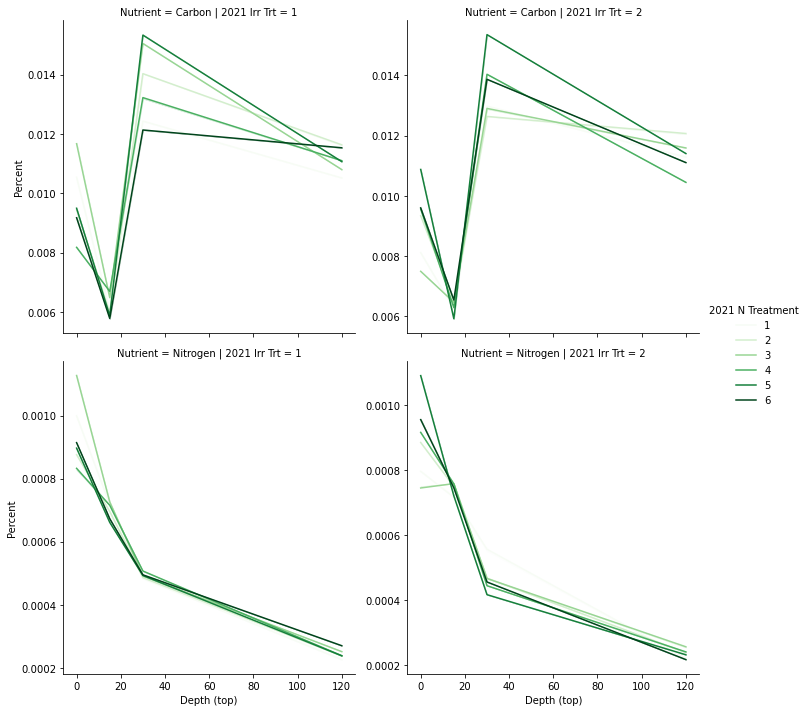

In [58]:
sns.relplot(y = 'Percent', x= 'Depth (top)', col= '2021 Irr Trt', hue= '2021 N Treatment', palette='Greens', 
                     data = weights_data_simple_melted, kind = 'line', row ='Nutrient', ci = False,
           facet_kws={'sharey': False, 'sharex': True})
plt.savefig('../Figures/2022_preseason_.jpg', spi = 300, bbox_inches = 'tight')

In [41]:
# normality test
# Plot residuals
# data_leaves['Clog'] = np.log(data_leaves['C'])
stat, p = shapiro(weights_data_simple['Carbon'])
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
    print('Sample looks Gaussian (fail to reject H0)')
else:
    print('Sample does not look Gaussian (reject H0)')

Statistics=0.965, p=0.000
Sample does not look Gaussian (reject H0)


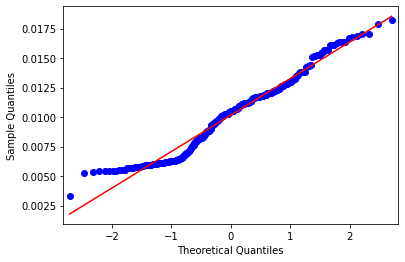

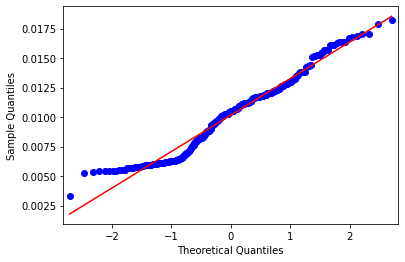

In [42]:
# QQ plot
sm.qqplot(weights_data_simple['Carbon'], line = 's')

In [64]:
weights_data_simple

,Carbon,Nitrogen,Depth,Wtrt,Ntrt
0,0.00895,0.000850,0,2,1
1,0.00885,0.000842,0,2,1
2,0.00601,0.000659,15,2,2
3,0.00598,0.000680,15,2,2
4,0.00755,0.000748,0,2,2
...,...,...,...,...,...
375,0.01440,0.000610,30,2,1
376,0.01700,0.000499,30,1,4
377,0.01050,0.000247,120,2,5
378,0.01180,0.000265,120,2,3


In [52]:
weights_data_simple.columns = ['Carbon', 'Nitrogen', 'Depth', 'Wtrt', 'Ntrt']

In [61]:
depth = 0
model = ols('Carbon ~ C(Wtrt) + C(Ntrt) + C(Wtrt):C(Ntrt)', data=weights_data_simple[weights_data_simple['Depth'] == depth]).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
anova_table

,sum_sq,df,F,PR(>F)
C(Wtrt),0.000009,1.0,3.844478,0.054406
C(Ntrt),0.000011,5.0,0.979003,0.437785
C(Wtrt):C(Ntrt),0.000082,5.0,7.274604,0.000020
Residual,0.000140,62.0,NaN,NaN


In [62]:
depth = 0
model = ols('Nitrogen ~ C(Wtrt) + C(Ntrt) + C(Wtrt):C(Ntrt)', data=weights_data_simple[weights_data_simple['Depth'] == depth]).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
anova_table

,sum_sq,df,F,PR(>F)
C(Wtrt),4.997201e-08,1.0,3.024700,0.086969
C(Ntrt),1.207546e-07,5.0,1.461804,0.215239
C(Wtrt):C(Ntrt),7.227532e-07,5.0,8.749343,0.000003
Residual,1.024322e-06,62.0,NaN,NaN


In [79]:
final_stats_df = pd.DataFrame()
for nutrient in ['Carbon','Nitrogen']:
    results_df = pd.DataFrame(columns = ['Nutrient','Effect','F (0)', 'P (0)', 'F (15)', 'P (15)', 'F (30)', 'P (30)', 'F (120)', 'P (120)'])
    for depth in [0, 15, 30, 120]:
        model = ols(nutrient + ' ~ C(Wtrt) + C(Ntrt) + C(Wtrt):C(Ntrt)', data=weights_data_simple[weights_data_simple['Depth'] == depth]).fit()
        anova_table = sm.stats.anova_lm(model, typ=2)
        results_df['F (' + str (depth) + ')'] = [anova_table['F'][0],anova_table['F'][1],anova_table['F'][2]]
        results_df['P (' + str (depth) + ')'] = [anova_table['PR(>F)'][0],anova_table['PR(>F)'][1],anova_table['PR(>F)'][2]]
    results_df['Nutrient'] = nutrient
    results_df['Effect'] = ['Wtrt','Ntrt','Wtrt:Ntrt']
    final_stats_df = pd.concat([final_stats_df, results_df])
final_stats_df

,Nutrient,Effect,F (0),P (0),F (15),P (15),F (30),P (30),F (120),P (120)
0,Carbon,Wtrt,3.844478,0.054406,1.661523,0.202345,0.013360,0.908354,1.518446,0.222434
1,Carbon,Ntrt,0.979003,0.437785,1.557214,0.186020,2.423089,0.045257,2.845305,0.022237
2,Carbon,Wtrt:Ntrt,7.274604,0.000020,1.325285,0.265755,1.452869,0.218236,1.925980,0.102467
0,Nitrogen,Wtrt,3.024700,0.086969,17.212828,0.000107,2.414599,0.125299,2.335907,0.131427
1,Nitrogen,Ntrt,1.461804,0.215239,2.169972,0.069325,1.524402,0.195259,2.337652,0.051954
2,Nitrogen,Wtrt:Ntrt,8.749343,0.000003,1.156966,0.340891,2.078098,0.080090,2.465351,0.041995


In [80]:
final_stats_df.to_csv('../Results/preseason_soil_carbon_nitrogen.csv', index=False)